In [226]:
import multiprocessing
import uuid
import os

if not os.path.exists('out'):
    os.makedirs('out')
if not os.path.exists('results'):
    os.makedirs('results')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.cm import ScalarMappable
mpl.rcParams["text.usetex"] = True

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction

In [2]:
target_name = 'SEIZ_updated'
threads_per_run = multiprocessing.cpu_count()
init_exposures = 100
epsilon = 2
batch_size = 10

parameter_space = ParameterSpace([ContinuousParameter('p', 0, 1),
                                  ContinuousParameter('l', 0, 1),
                                  DiscreteParameter('prop_init_skeptics', np.arange(1, init_exposures, 1, dtype=np.int_))])

In [3]:
def run_job(p, l, init_skeptics, init_adopters):
    with open(f'{target_name}_editable.fred', 'r') as file:
        filedata = file.read()

    vars = {
        'p': p, 
        'l': l, 
        'epsilon': epsilon, 
        'init_skeptic': int(init_skeptics), 
        'init_adopt': int(init_adopters)
    }

    run_uuid = uuid.uuid4()
    var_str = ', '.join(map(lambda item: f'{item[0]}={item[1]}', vars.items()))
    print(run_uuid, var_str)

    with open(f'out/{target_name}_{run_uuid}_out.fred', 'w') as file:
        file.write(filedata.format(**vars))
        
    !fred_job -p out/{target_name}_{run_uuid}_out.fred -k {target_name}_{run_uuid}_run -t {threads_per_run}
    !fred_csv -k {target_name}_{run_uuid}_run > results/{target_name}_{run_uuid}_run.csv

    with open(f'results/{target_name}_{run_uuid}_run.csv', 'r') as file:
        lines = file.readlines()

    with open(f'results/{target_name}_{run_uuid}_run.csv', 'w') as file:
        lines[0] = var_str+'\n'
        file.writelines(lines)

    return pd.read_csv(f'results/{target_name}_{run_uuid}_run.csv', header=2)

In [4]:
def sample(X, clear_results=False):
    X = np.array(X)
    
    if X.ndim < 2:
        X = np.expand_dims(X, 0)
    elif X.ndim > 2:
        raise Exception(f'X has too many dimensions (ndim={X.ndim}, must be 1 or 2)')
    if X.shape[-1] != parameter_space.dimensionality:
        raise Exception(f'X has the wrong number of variables (variables={X.shape[-1]}, must be {parameter_space.dimensionality})')

    X = np.append(X, np.expand_dims(init_exposures-X[:,-1], axis=1), axis=1)  # create and add init_adopters variable

    if clear_results:
        !yes | fred_clear_all_results
    
    Y = []

    with multiprocessing.Pool() as pool:
        for data in pool.starmap(run_job, X):
            S_count = data['ADOPT.totS'].iat[0]
            Y.append([(-data['ADOPT.S'].diff()).max() / S_count])
        
    return np.vstack(Y)

In [5]:
design = LatinDesign(parameter_space)
num_data_points = batch_size
X = design.get_samples(num_data_points)

In [6]:
X

array([[9.5e-01, 7.5e-01, 3.5e+01],
       [1.5e-01, 1.5e-01, 6.5e+01],
       [6.5e-01, 6.5e-01, 4.5e+01],
       [5.0e-02, 5.5e-01, 1.6e+01],
       [7.5e-01, 8.5e-01, 9.4e+01],
       [4.5e-01, 5.0e-02, 2.5e+01],
       [5.5e-01, 3.5e-01, 8.4e+01],
       [8.5e-01, 9.5e-01, 7.4e+01],
       [3.5e-01, 2.5e-01, 5.5e+01],
       [2.5e-01, 4.5e-01, 6.0e+00]])

In [7]:
Y = sample(X, clear_results=True)

You are about to delete /home/nyoma/FRED/RESULTS. This cannot be undone.
Proceed? yes/no [no]
/home/nyoma/FRED/RESULTS deleted
yes: standard output: Broken pipe
2452ebf3-e889-4779-ad5a-14ab7b68bd355886bc22-cc7a-401f-8522-71bbb0c30fc795e1aa7f-3003-453e-a7de-8a8f7839e5e1ce64b20d-e886-44c1-b165-52cd0b67d51485e41bfa-413b-4cb1-9191-8b21e71c2f52ddfeafdc-2b6d-499a-98ab-1aa468f5e7e8 72faa1b7-e522-4487-a69c-635386a50de88ca169e4-f52c-438e-9fa6-dfbd4c329da7afc6a50c-78af-4c88-b033-95289a0ad8497553b580-eb88-4c24-b4d1-f88acf04d87e    p=0.75, l=0.8500000000000001, epsilon=2, init_skeptic=94, init_adopt=6     p=0.05, l=0.55, epsilon=2, init_skeptic=16, init_adopt=84p=0.95, l=0.75, epsilon=2, init_skeptic=35, init_adopt=65p=0.15000000000000002, l=0.15000000000000002, epsilon=2, init_skeptic=65, init_adopt=35p=0.35000000000000003, l=0.25, epsilon=2, init_skeptic=55, init_adopt=45p=0.55, l=0.35000000000000003, epsilon=2, init_skeptic=84, init_adopt=16
p=0.45, l=0.05, epsilon=2, init_skeptic=25, init_adop

In [8]:
Y

array([[0.06942054],
       [0.05543051],
       [0.06227106],
       [0.05732821],
       [0.02630301],
       [0.0676111 ],
       [0.0619842 ],
       [0.01780749],
       [0.06189594],
       [0.0560925 ]])

In [9]:
model_gpy = GPRegression(X,Y)
model_emukit = GPyModelWrapper(model_gpy)

In [10]:
model_variance = ModelVariance(model=model_emukit)
expdesign_loop = ExperimentalDesignLoop(model=model_emukit,
                                        space=parameter_space,
                                        acquisition=model_variance,
                                        batch_size=batch_size)

max_iterations = 25
expdesign_loop.run_loop(sample, max_iterations)

c002dec3-1653-4329-af65-6c3e1109f6052a668db3-e592-4b23-977a-18a012ceca05b8210c84-353c-4e30-95d7-eaea8e667372364a66d6-4749-48e7-8fb0-f59dd37ec65112c4c6df-12de-4779-af7b-e6adc28d9165c36c43a7-ec7d-4ce7-9593-4813ce3b24dfd6f2f972-3e99-4716-9b81-812593f58997eabd8bdd-c5b4-420b-900d-b7ed7765081eebb912fb-7d62-4aa7-9db8-375b226357d29c14f59d-5172-4e2b-a818-600f41d94116          p=0.23567866840105378, l=0.21745767061227483, epsilon=2, init_skeptic=99, init_adopt=1p=0.02809603727963017, l=0.9378785941562008, epsilon=2, init_skeptic=30, init_adopt=70p=0.9973577689064757, l=0.9738456662297788, epsilon=2, init_skeptic=60, init_adopt=40p=0.9148138924180125, l=0.8853934296423266, epsilon=2, init_skeptic=1, init_adopt=99p=0.020053131723902995, l=0.7461185190075786, epsilon=2, init_skeptic=79, init_adopt=21p=0.11016041515395802, l=0.11915076237538058, epsilon=2, init_skeptic=40, init_adopt=60p=0.007743638972720568, l=0.4651782958526589, epsilon=2, init_skeptic=89, init_adopt=11p=0.9813171418199973, l=0.87

In [11]:
domain = []

for parameter in parameter_space.parameters:
    if isinstance(parameter, ContinuousParameter):
        domain.append(np.linspace(*parameter.bounds[0], 100))
    elif isinstance(parameter, DiscreteParameter):
        domain.append(parameter.domain)
    else:
        raise NotImplementedError(f'Domain computation not implemented for parameter type {type(parameter)}')

xx_p, yy_l, zz_init_skeptics = np.meshgrid(*domain)

In [12]:
predictions = model_emukit.predict(np.stack((xx_p, yy_l, zz_init_skeptics), axis=-1).reshape(-1, parameter_space.dimensionality))[0].reshape(xx_p.shape)

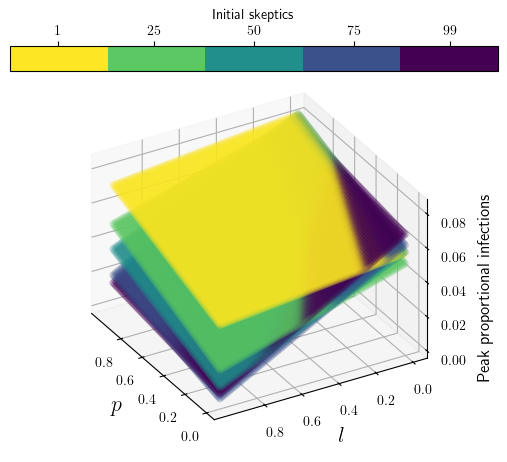

In [278]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

init_slice = [0,24,49,74,-1] # this gets values with init_skeptics = 1, 25, 50, 75, or 99
cmap = mpl.cm.get_cmap('viridis_r', len(init_slice))

color_dim = zz_init_skeptics[:,:,init_slice]

ax.scatter(xx_p[:,:,init_slice], yy_l[:,:,init_slice], predictions[:,:,init_slice], c=color_dim, cmap=cmap, alpha=0.15)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1,0.2))
ax.set_yticks(np.arange(0,1,0.2))
ax.set_zticks(np.arange(0,0.1,0.02))

# ax.zaxis.set_major_formatter(ScalarFormatter(useOffset=False))

norm = plt.Normalize(-11, 111)
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, ticks=np.unique(color_dim), label='Initial skeptics', orientation='horizontal', shrink=0.8, location='top', pad=0)
# cbar.ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

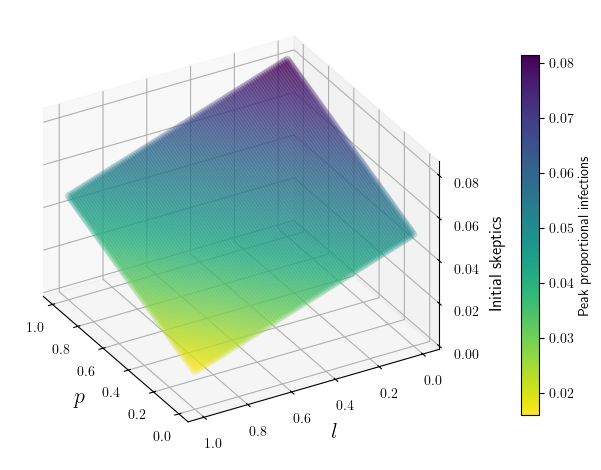

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

init_slice = 29

cmap = plt.get_cmap('viridis_r')

color_dim = predictions[:,:,init_slice]

ax.scatter(xx_p[:,:,init_slice], yy_l[:,:,init_slice], color_dim, c=color_dim, cmap=cmap, alpha=0.15)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Peak proportional infections', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_zticks(np.arange(0,0.1,0.02))

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

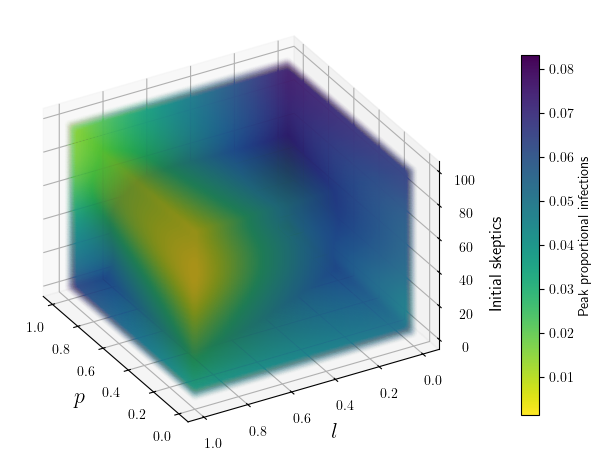

In [310]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis_r')

color_dim = predictions

ax.scatter(xx_p, yy_l, zz_init_skeptics, c=color_dim, cmap=cmap, alpha=0.01)

ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('$l$', fontsize=16)
ax.set_zlabel('Initial skeptics', fontsize=12)

ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_zticks(np.arange(0,101,20))

norm = plt.Normalize(color_dim.min(), color_dim.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1, label='Peak proportional infections')

ax.view_init(30, 150, 0)

plt.tight_layout()

plt.show()

In [427]:
def group_mean(x,y):
    df = pd.DataFrame(np.stack((x.ravel(),y.ravel()), axis=1)).groupby(0).mean()
    return df.index.to_numpy(), df[1].to_numpy() 

def group_std(x,y):
    df = pd.DataFrame(np.stack((x.ravel(),y.ravel()), axis=1)).groupby(0).std()
    return df.index.to_numpy(), df[1].to_numpy() 

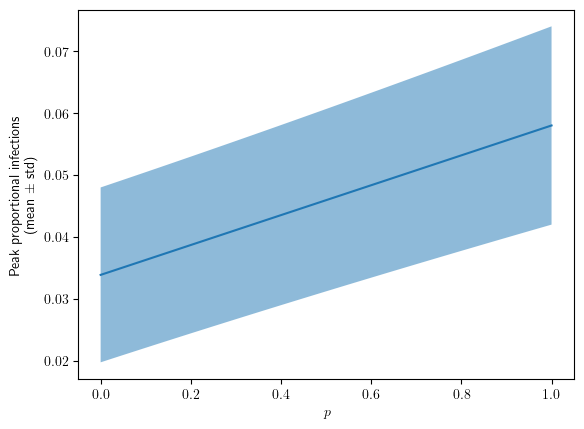

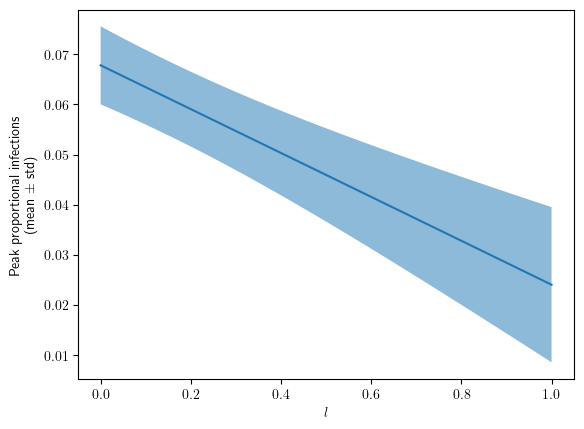

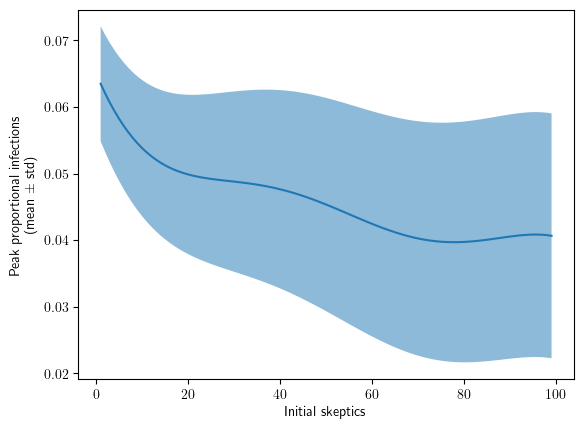

In [438]:
p_mean_idx, p_pred_mean = group_mean(xx_p, predictions)
p_std_idx, p_pred_std = group_std(xx_p, predictions)
# plt.scatter(xx_p.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(p_mean_idx, p_pred_mean)
plt.fill_between(p_std_idx, p_pred_mean+p_pred_std, p_pred_mean-p_pred_std, alpha=0.5)
plt.xlabel('$p$')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

l_mean_idx, l_pred_mean = group_mean(yy_l, predictions)
l_std_idx, l_pred_std = group_std(yy_l, predictions)
# plt.scatter(yy_l.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(l_mean_idx, l_pred_mean)
plt.fill_between(l_std_idx, l_pred_mean+l_pred_std, l_pred_mean-l_pred_std, alpha=0.5)
plt.xlabel('$l$')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()

z_mean_idx, z_pred_mean = group_mean(zz_init_skeptics, predictions)
z_std_idx, z_pred_std = group_std(zz_init_skeptics, predictions)
# plt.scatter(zz_init_skeptics.ravel(), predictions.ravel(), alpha=1/255, s=5)
plt.plot(z_mean_idx, z_pred_mean)
plt.fill_between(z_std_idx, z_pred_mean+z_pred_std, z_pred_mean-z_pred_std, alpha=0.5)
plt.xlabel('Initial skeptics')
plt.ylabel('Peak proportional infections\n(mean $\pm$ std)')
plt.show()